  Aerosol- und Nanotechnologie II |  Friederike Baumgart | Matr.-Nr. 4343944 | Abgabe: 01.05.22

  markiert 02.05.22 (Stefan Endres)
  
 Finale: 1.0


Task 1:
=======
#### Grade: 30 (/30)
#### Comments: Completed task correctly, numerical output matches analytical solution for tested parameter space.



In [1]:
t1 = 30  # /30

Task 2:
=======
#### Grade: 40 / 50
#### Comments:

- Note that the time discretisation used ($\frac{\partial n(v_\mathrm{p}, t)}{\partial t} \approx \frac{n_{i})(t)- n_{i}(t-\Delta t )}{\Delta t } $) is unusual ($\frac{\partial n(v_\mathrm{p}, t)}{\partial t} \approx \frac{n_{i}(t+\Delta t )- n_{i}(t)}{\Delta t } $ is preferred in most numerical methods) and this also led to a fundamentally incorrect algebraic equation (equation 3 $n(t) = \frac{n(t-1) + Q n_0(v_\mathrm{min}) \Delta t - B \Delta n_\mathrm{formed}}{1 + Q \Delta t}$ is wrong)). Between the time period $n-1$ and $n$ the differential ($\frac{\partial n(v_\mathrm{p}, t)}{\partial t} \approx f(v_\mathrm{p}, t)$  should be using the number vector $n-1$ at the current time, rather than the future vector $n$ that you are integrating towards in time). In fact, your code does actually use $n-1$ instead of $n$ (since you don't actually have $n$), but then the derivation of your discretization is wrong. The correct discretisation of 
$$
\frac{\partial n(v_\mathrm{p}, t)}{\partial t} = -B \Delta n + Q n_0(v_\mathrm{p, min}) - Q n(v_\mathrm{p}, t)
\label{eq:mass balance}\tag{1}
$$

is, from MOL (correct):

$$
\frac{n_{i}(t)- n_{i}(t-\Delta t )}{\Delta t } = - B \cdot \Delta n  + Q \cdot n^{0}  -  n_{i}(t-\Delta t ) Q  ~~, \forall n>0
$$

$$
n_{i}(t) = n_{i}(t-\Delta t )  + \Delta t \left(  - B \cdot \Delta n  + Q \cdot n^{0}  -  n_{i}(t-\Delta t ) Q \right) ~~, \forall n>0
$$

and not (incorrect):

$$
\frac{n_{i}(t) - n_{i}(t - \Delta t) }{\Delta t } = - B \cdot \Delta n  + Q \cdot n^{0}  -  n^{n}_{i} Q 
$$


...which led to the incorrect derivation 
$$n(t) = \frac{n(t-\Delta t) + Q n_0(v_\mathrm{min}) \Delta t - B \Delta n_\mathrm{formed}}{1 + Q \Delta t}.$$

$$
\frac{\partial n(v_\mathrm{p}, t)}{\partial t}  = - B \cdot \Delta n  + Q \cdot n^{0}  -  n^{n}_{i} Q 
$$


An example of the correct discretisation loop is:

```python
nn = np.empty_like(n)
n_formed = np.empty_like(n)
n_in = np.empty_like(n)
n_in[1] = N_0
for t in range(nt - 1):
    nn = n.copy()
    for i in range(1, vp_num, 1):
        sum1 = np.zeros((vp_num))
        sum2 = np.zeros((vp_num))
        sum3 = np.zeros((vp_num))
        for j in range(0, i - 1, 1):
            sum1[i] = sum1[i] + (2**(j-i+1) * beta_n[i-1,j] * nn[j])
        for j in range(0, i - 0, 1):    
            sum2[i] = sum2[i] + (2**(j-i) * beta_n[i,j] * nn[j])
        for j in range(i, vp_num - 1, 1): 
            sum3[i]= sum3[i] + (beta_n[i,j] * nn[j])
        n_formed[i] = nn[i] + dt * ( \
                             nn[i-1] * sum1[i] + \
                             1/2 * beta_n[i-1,i-1] * nn[i-1]**2 - \
                             nn[i] * sum2[i] - \
                             nn[i] * sum3[i]     
                             )
        n[i] = nn[i] + dt * (B * n_formed[i] + Q * n_in[i] - nn[i] * Q)
```

Comparing the differences between the solution vectors $n$ at time t = 5:

```array([ 0.00000000e+00, -6.26378960e+16, -4.87145036e+16, -3.92418246e+16,
       -3.51828851e+16, -3.12161042e+16, -2.71540984e+16, -2.43346634e+16,
       -2.42287104e+16, -2.31499853e+16, -1.58819247e+16, -6.24264656e+15,
       -1.20462276e+15, -1.04680398e+14, -4.05974524e+12, -7.33986636e+10,
       -6.51447293e+08, -2.95364460e+06, -6.99743390e+03, -8.51330183e+00,
       -4.23160971e-03,  1.73748898e-06,  4.16479869e-09,  3.07258052e-12,
        1.28108638e-15,  3.26572535e-19,  5.16868315e-23,  5.09048274e-27,
        3.11709298e-31,  1.18468555e-35,  2.78901052e-40,  4.05896508e-45,
        3.64488791e-50,  2.01625280e-55])```

Although this appears drastic, the actual differences in the solutions are quite small:

Your solution (at t = 5 s):
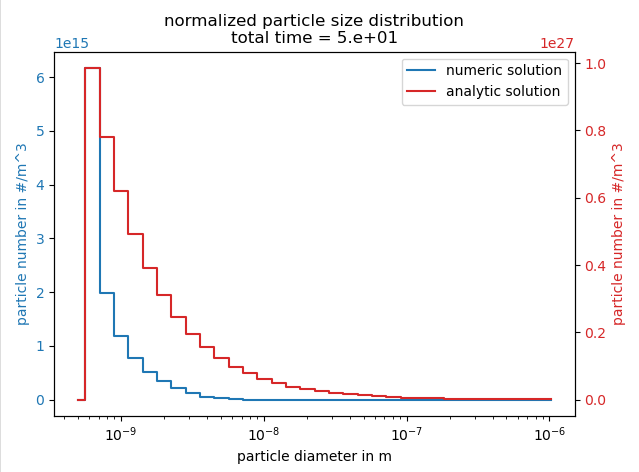

Our solution (at t = 5 s):

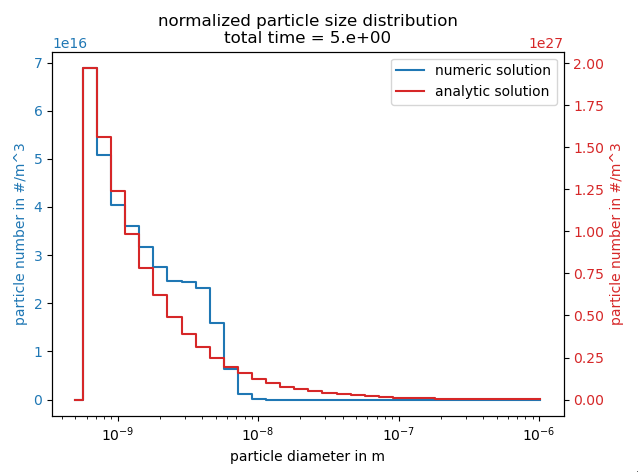

The small difference is due to the approximations differing only by a constant factor, which only becomes more pronounced over time.

- Another mistake is found in the line: `n_formed[i] = dt *(- nn[i] * sum2[i] - nn[i] * sum3[i])  `, note that for `i==1` the `nn[i-1] * sum1[i]` term should still be included.

- Further note that for the purposes of numerical stability it is better to define a `delta_t` timestep and than compute the number of discrete time elements needed for a given timespan.

In [19]:
t2 = 40

Task 3:
=======
#### Grade: 50 (/50)
#### Comments: 
Completed task correctly using an objective function to find the optimal reactor design. Note that instead of using the loop presented where the solution approaches the minimum from one side of the domain with manually entered tolerances, it is better in general to used a (numerical) gradient estimate of the objective function which will automatically lower the step size as you approach the minimum for well behaved problems such as this (this is how a large class of optimization algorithms work!).


In [20]:
t3 = 50



Total grade: (/100)
============

In [21]:
tf = min([t1 + t2 + t3, 100])
print(f'Final grade (%): {tf}')
print(f'Final grade: {3*(100 -tf)/100.0 + 1}')

Final grade (%): 100
Final grade: 1.0
